In [1]:
#oznaczyc kanaly ktore cechowaly sie na poczatku duza wariancja. Sprawdzalismy to wczesniej 
#wyznaczyc ich segmenty gdzie jest ten duzy niefizjologiczny pik
#zrobic znowu ica
#porownac wyniki ica i klasyfikatora - ile other ile nie other 
#w pracy napisac - jesli oznaczenie tych segmentow przyniesie dobry rezultat: wykres wariancji, screeny gdzie sa te segmenty
#opisac wszystkie artefakty to

In [1]:
import mne 
import matplotlib.pyplot as plt
import numpy as np 
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs #funkcje ica
from mne_icalabel import label_components #ica-label algorytm
import onnxruntime #biblioteka do obsługi ica-label
#backend matplotliba 
%matplotlib qt 

In [2]:
"""USTAWIENIA DO ZAŁADOWANIA DANYCH"""
d_path = "eeg_files/20241017_kp.bdf" 
ch_eog = ["EXG1","EXG2"] #kanaly eog
ch_ecg = ["EXG3","EXG4"] #kanaly ecg
ch_exclude = [f"EXG{i}" for i in range(5,9)]



In [3]:
"""ZAŁADOWANIE DANYCH I USTAWIENIE UKŁADU ELEKTROD"""
raw = mne.io.read_raw_bdf(
    d_path, preload = True, eog = ch_eog, misc = ch_ecg, exclude = ch_exclude 
)
raw.set_montage("biosemi64") #ustawienie montazu biosemi
#załadowanie danych

Extracting EDF parameters from /Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/eeg_files/20241017_kp.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2928639  =      0.000 ...  1430.000 secs...


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [4]:
"""PARAMETRY FILTRACJI"""
bandpass_low = 0.1 #dolne pasmo
bandpass_high = 50 #górne pasmo
notch = 50 
raw.notch_filter(notch)
raw.filter(bandpass_low,bandpass_high) 


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 67585 samples (33.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [5]:
"""USTAWIENIE REFERENCJI"""
raw.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [6]:
"""USTAWIENIE ADNOTACJI DLA SEGMENTÓW Z ARTEFAKTEM RUCHOWYM"""
onset_bad_segments = [492.0,1346.0,965.0]
duration_bad_segments = [14.0,22.0,20.0]
description_bad_segments = ["BAD_Oz_movement_artifact","BAD_movement_POz_artifact","BAD_movement_artifact"]
my_annotations = mne.Annotations(onset=onset_bad_segments,duration=duration_bad_segments,description=description_bad_segments)
raw.set_annotations(my_annotations)

<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

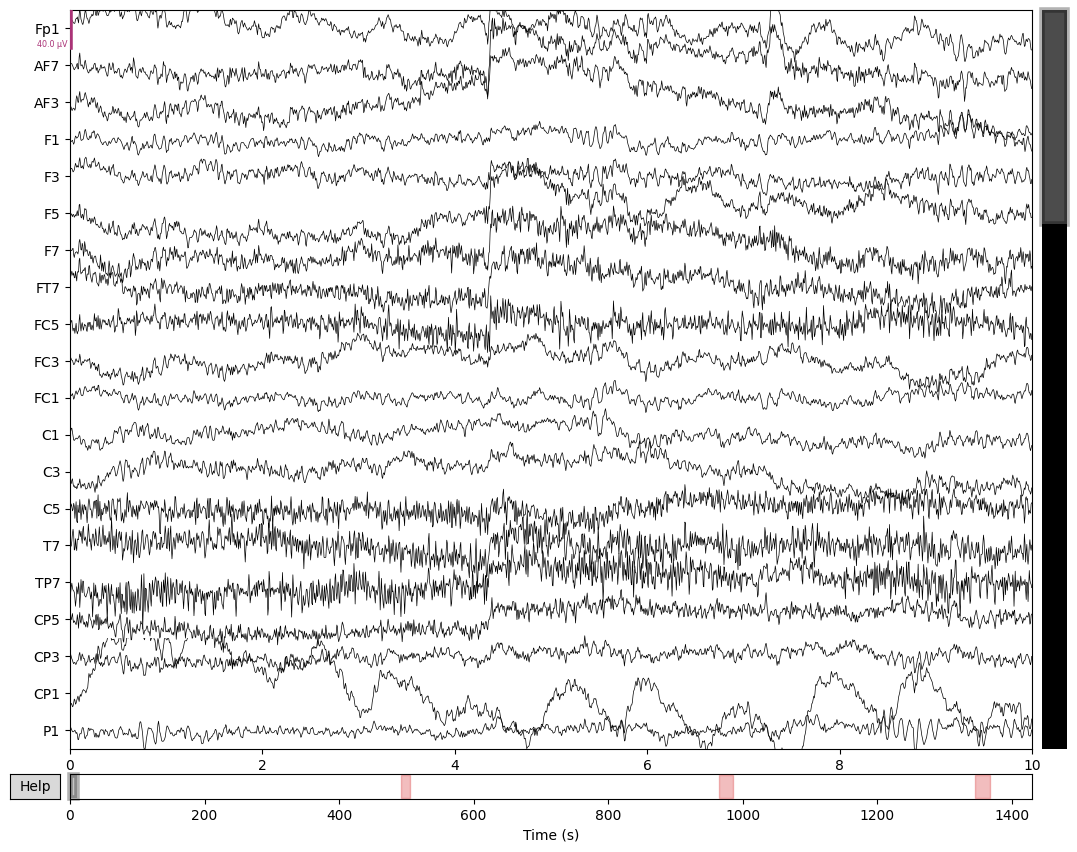

Channels marked as bad:
none


In [8]:
raw.plot()

In [34]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2),ch_name=ch_eog)
eog_evoked = eog_epochs.average()


Using EOG channels: EXG1, EXG2
EOG channel index for this subject is: [64 65]
Omitting 114688 of 2928640 (3.92%) samples, retaining 2813952 (96.08%) samples.
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EXG2 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 80 significant peaks
Number of EOG events detected: 80
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded R

In [36]:
print(eog_evoked)

<Evoked | '998' (average, N=78), -0.5 – 0.5 s, baseline -0.5 – -0.2 s, 64 ch, ~1.1 MiB>


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


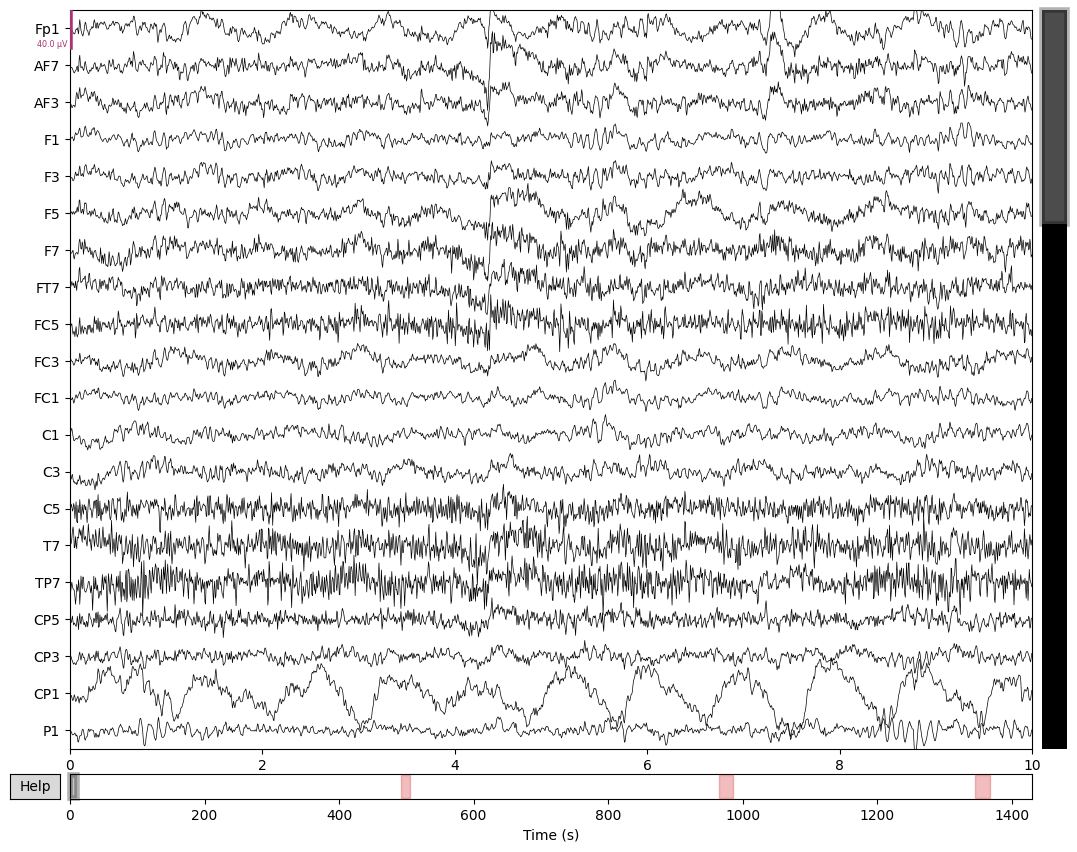

Channels marked as bad:
none


In [13]:
"""DOSTOSOWANIE POD ICA"""

filt_raw = raw.copy().filter(l_freq=1.0, h_freq=100.0)#dla algorytmu ica-label
filt_raw.set_montage("biosemi64")
filt_raw.set_eeg_reference("average")
filt_raw.plot()


In [30]:
#"""ZAINICJOWANIE ALGORYTMU ICA"""
#ica = ICA(
#    max_iter="auto",  #automatyczna liczba iteracji
#    method="infomax",  #wymog ica-label
#    random_state=97, #ziarno
#    fit_params=dict(extended=True), #wymog ica-label
#)
#ica.fit(filt_raw,reject_by_annotation=True)  

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Omitting 114688 of 2928640 (3.92%) samples, retaining 2813952 (96.08%) samples.
Selecting by non-zero PCA components: 63 components
Computing Extended Infomax ICA
Fitting ICA took 706.4s.


Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,500 iterations on raw data (2813952 samples)
ICA components,63
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


In [45]:
#ica.save("more_bad_segments-ica.fif",overwrite=True,verbose=None)

Writing ICA solution to /Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/more_bad_segments-ica.fif...


Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,500 iterations on raw data (2813952 samples)
ICA components,63
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


In [10]:
ica=mne.preprocessing.read_ica("/Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/more_bad_segments-ica.fif")

Reading /Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/more_bad_segments-ica.fif ...
Now restoring ICA solution ...
Ready.


Creating RawArray with float64 data, n_channels=65, n_times=2928640
    Range : 0 ... 2928639 =      0.000 ...  1430.000 secs
Ready.


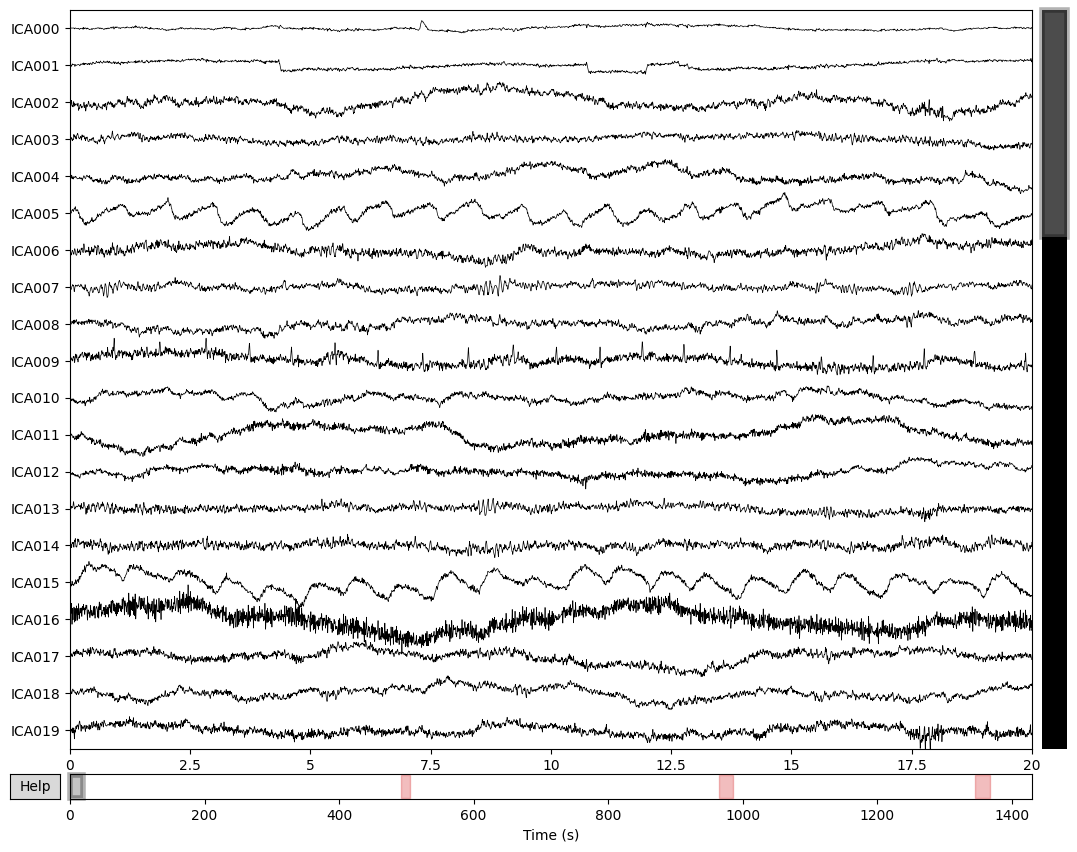

In [11]:
ica.plot_sources(raw)

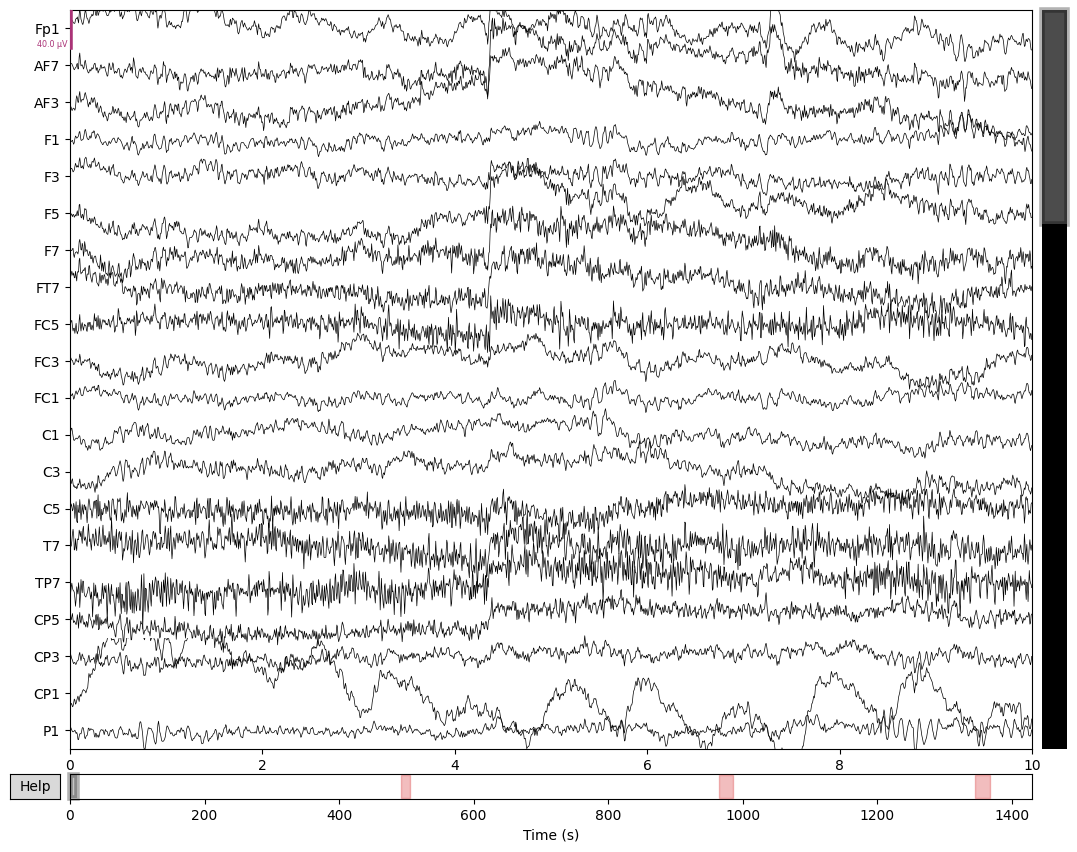

In [41]:
raw.plot()

In [14]:
ic_labels_1 = label_components(filt_raw, ica, method='iclabel')
labels_1 = ic_labels_1["labels"]

/var/folders/vc/x50hw5690nj406s2rv6052180000gn/T/ipykernel_82313/1004248538.py:1: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels_1 = label_components(filt_raw, ica, method='iclabel')


In [15]:
labels_list = ic_labels_1["labels"]
count_other = labels_list.count("other")

print(f"Liczba komponentów oznaczonych jako 'other': {count_other}")
print(count_other)

Liczba komponentów oznaczonych jako 'other': 19
19


In [16]:
print(ic_labels_1)

{'y_pred_proba': array([0.9931615 , 0.99962723, 0.6643087 , 0.9999602 , 0.7289887 ,
       0.86134535, 0.9387392 , 0.8441882 , 0.93859464, 0.71645224,
       0.72613764, 0.6598127 , 0.35699773, 0.99706125, 0.99886525,
       0.4936159 , 0.6370255 , 0.8382656 , 0.7022394 , 0.65194464,
       0.5228324 , 0.43357304, 0.3264802 , 0.36040857, 0.8532585 ,
       0.7054596 , 0.94848543, 0.9747945 , 0.73662263, 0.5043081 ,
       0.82339746, 0.98962814, 0.9957949 , 0.4135898 , 0.8452804 ,
       0.9491563 , 0.9313947 , 0.37936574, 0.99613273, 0.82881385,
       0.7764015 , 0.9646989 , 0.9806808 , 0.38151348, 0.96003807,
       0.4936695 , 0.7044546 , 0.5573993 , 0.5108477 , 0.8641403 ,
       0.6192102 , 0.5057199 , 0.9171918 , 0.8071102 , 0.95979416,
       0.5620832 , 0.8782842 , 0.53143764, 0.77200526, 0.85202014,
       0.26146013, 0.64829636, 0.68063056], dtype=float32), 'labels': ['eye blink', 'eye blink', 'other', 'brain', 'eye blink', 'other', 'brain', 'brain', 'other', 'heart beat', '

Creating RawArray with float64 data, n_channels=3, n_times=2928640
    Range : 0 ... 2928639 =      0.000 ...  1430.000 secs
Ready.


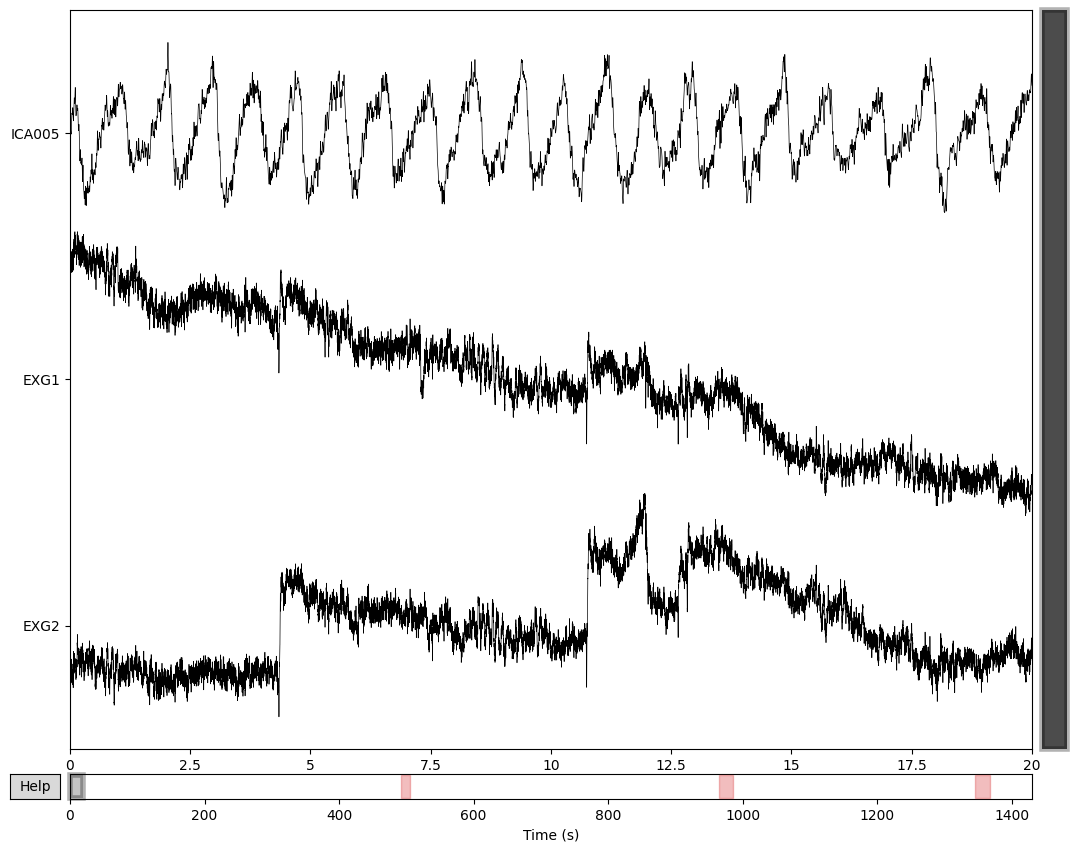

In [25]:
ica.plot_sources(filt_raw,picks=[5])


Applying ICA to Raw instance
    Transforming to ICA space (63 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


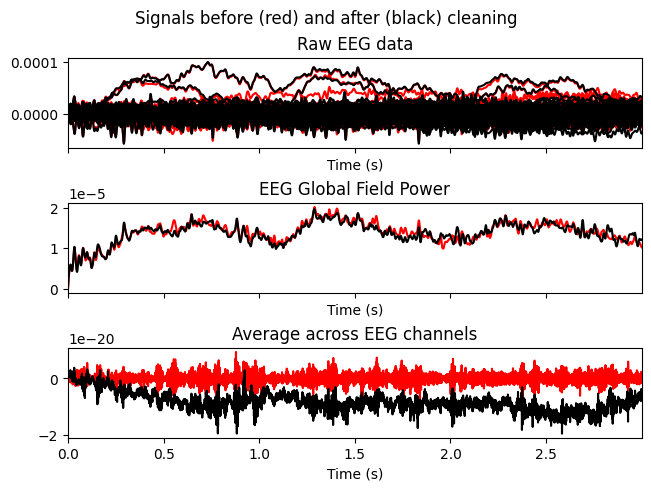

In [44]:
ica.plot_overlay(raw,exclude=[0,1])

In [1]:
ica.plot_properties(filt_raw,picks=[11])

NameError: name 'ica' is not defined

In [41]:
eog_indices, eog_scores = ica.find_bads_eog(filt_raw)
print(eog_indices)

Using EOG channels: EXG1, EXG2
Omitting 114688 of 2928640 (3.92%) samples, retaining 2813952 (96.08%) samples.
Omitting 114688 of 2928640 (3.92%) samples, retaining 2813952 (96.08%) samples.
Omitting 114688 of 2928640 (3.92%) samples, retaining 2813952 (96.08%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

Omitting 114688 of 2928640 (3.92%) samples, retaining 2813952 (96.08%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

[np.int64(1), np.int64(0), np.int64(3), np.int64(4)]
